# CNN Training in PyTorch and Deployment in C++ 

## 1. Objective

The goal of this project is to bridge high-level deep learning frameworks and low-level optimized C++ implementations.

We will:

1. Train a simple Convolutional Neural Network (CNN) in PyTorch on a medical dataset.
2. Extract the trained weights (Conv2D and Fully Connected layer).
3. Import those weights into our custom C++ inference engine.
4. Run inference using:
   - Baseline implementation
   - SSE implementation
   - AVX implementation
5. Compare:
   - accuracy
   - speed
   
---

## 2. Dataset

We use the Chest X-Ray Pneumonia dataset, which contains pediatric chest radiographs categorized into:

- Normal

- Pneumonia

This is a binary classification problem.
All images are converted to:

- Grayscale (1 channel)

- 64 × 64 resolution

- Float tensors in range [0, 1]

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import os

import copy
from PIL import Image

import subprocess
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
torch.manual_seed(42)
np.random.seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
IMG_SIZE = 64

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor()
    #transforms.Normalize((0.5,), (0.5,))
])

In [4]:
data_dir = "./chest_xray"

train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(data_dir, "train"),
    transform=transform
)

val_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(data_dir, "val"),
    transform=transform
)

test_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(data_dir, "test"),
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

print("Classes:", train_dataset.classes)

Classes: ['NORMAL', 'PNEUMONIA']


### Data Loading Strategy

We use torchvision.datasets.ImageFolder, which automatically assigns labels based on directory structure.

DataLoaders are configured as:

- Batch size: 32

- Shuffle enabled for training

- No shuffle for validation and test

This ensures stable validation and reproducible benchmarking.

### Model Architecture 

Input: 1 × 64 × 64
Conv (1 → 1, 3×3, stride=1)

ReLU

Flatten 


Fully Connected (62×62 → 2)

In [5]:
class Model(nn.Module): 
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=3,
            stride=1,
            bias=False
        )
        
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(62*62, 2)
        
    def forward(self, x): 
        x = self.conv(x)
        x = self.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [6]:
model = Model().to(device)
model 

Model(
  (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (relu): ReLU()
  (fc): Linear(in_features=3844, out_features=2, bias=True)
)

### Architecture Rationale

The CNN architecture is intentionally minimal:

- One 3×3 Conv2D layer

- ReLU activation

- One Fully Connected layer

This design is chosen for two reasons:

1. Direct compatibility with our custom C++ inference engine

2. Clear isolation of Conv2D performance impact

Because there is no padding:

$$
64 × 64 → 62 × 62
$$

Thus the fully connected layer input size is:

$$
62 × 62 = 3844
$$

### Training Configuration

- Loss Function: CrossEntropyLoss

- Optimizer: Adam (lr = 0.001)

- Epochs: 5

- Best model selected based on validation accuracy

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
EPOCHS = 5

best_val_acc = 0.0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss/len(train_loader):.4f} "
          f"Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())

Epoch [1/5] Train Loss: 0.3484 Val Acc: 81.25%
Epoch [2/5] Train Loss: 0.1837 Val Acc: 81.25%
Epoch [3/5] Train Loss: 0.1702 Val Acc: 81.25%
Epoch [4/5] Train Loss: 0.1560 Val Acc: 93.75%
Epoch [5/5] Train Loss: 0.1415 Val Acc: 81.25%


In [9]:
model.load_state_dict(best_model_state)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

Best Validation Accuracy: 93.75%


In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
accuracy = 100 * correct / total 
print(f"Test Accuracy (PyTorch): {accuracy:.2f}%")

Test Accuracy (PyTorch): 80.13%


In [11]:
print("Conv weight shape: ", model.conv.weight.shape)
print("FC weight shape: ", model.fc.weight.shape)
print("FC bias shape: ", model.fc.bias.shape)

Conv weight shape:  torch.Size([1, 1, 3, 3])
FC weight shape:  torch.Size([2, 3844])
FC bias shape:  torch.Size([2])


In [12]:
conv_weight = model.conv.weight.detach().cpu().numpy()

kernel_3x3 = conv_weight[0, 0]

print("Kernel shape after squeeze: ", kernel_3x3.shape)
kernel_3x3

Kernel shape after squeeze:  (3, 3)


array([[ 0.31133607,  0.3336681 , -0.03638306],
       [ 0.36190796, -0.01344205,  0.11392258],
       [-0.12376984,  0.24082199,  0.33059365]], dtype=float32)

## Weight Extraction for C++ Deployment

To run inference in C++, we must export:

- 3×3 convolution kernel

- Fully connected weights

- Fully connected bias

Weights are saved as plain text files to simplify parsing inside the C++ engine.

In [13]:
store_dir = "infer_test"

os.makedirs(store_dir, exist_ok=True)

kernel_path = os.path.join(store_dir, "kernel_3x3.txt")
fc_weight_path = os.path.join(store_dir, "fc_weight.txt")
fc_bias_path = os.path.join(store_dir, "fc_bias.txt")

In [14]:
np.savetxt(
    kernel_path,
    kernel_3x3.reshape(-1),
    fmt="%.10f"
)

In [15]:
fc_weight = model.fc.weight.detach().cpu().numpy()

print("FC weight shape: ", fc_weight.shape)

np.savetxt(
    fc_weight_path,
    fc_weight.reshape(-1),
    fmt="%.10f"
)

FC weight shape:  (2, 3844)


In [16]:
fc_bias = model.fc.bias.detach().cpu().numpy()

print("FC bias shape: ", fc_bias.shape)

np.savetxt(
    fc_bias_path,
    fc_bias,
    fmt="%.10f"
)

FC bias shape:  (2,)


### Verification Step

We reload the saved files to verify:

- Correct number of elements

- No truncation or formatting errors

In [17]:
kernel_test = np.loadtxt(kernel_path)
fc_weight_test = np.loadtxt(fc_weight_path)
fc_bias_test = np.loadtxt(fc_bias_path)

print("Kernel elements:", kernel_test.shape)
print("FC weight elements:", fc_weight_test.shape)
print("FC bias elements:", fc_bias_test.shape)

Kernel elements: (9,)
FC weight elements: (7688,)
FC bias elements: (2,)


### Tensor Export for C++ Inference

PyTorch tensors cannot be directly consumed by our C++ engine.

Therefore:

- Each test image is transformed

- Converted to float32

- Stored as raw binary (.bin)

In [18]:
def save_image_as_tensor(input_path, output_path):
    
    # Load image
    img = Image.open(input_path)

    # Apply transform
    x = transform(img)  

    # Convert to numpy float32
    x_np = x.numpy().astype(np.float32)

    # Save raw binary
    x_np.tofile(output_path)

In [26]:
def save_images_as_tensor(input_dir, output_dir, transform):

    if not os.path.exists(input_dir):
        raise ValueError(f"Input directory does not exist: {input_dir}")

    os.makedirs(output_dir, exist_ok=True)

    supported_ext = (".png", ".jpg", ".jpeg", ".bmp")

    for root, _, files in os.walk(input_dir):
        for file in files:
            if not file.lower().endswith(supported_ext):
                continue

            input_path = os.path.join(root, file)

            # Preserve relative folder structure
            rel_path = os.path.relpath(input_path, input_dir)
            rel_dir  = os.path.dirname(rel_path)

            save_dir = os.path.join(output_dir, rel_dir)
            os.makedirs(save_dir, exist_ok=True)

            output_path = os.path.join(
                save_dir,
                os.path.splitext(file)[0] + ".bin"
            )

            try:
                img = Image.open(input_path)
                x = transform(img)                # (1, H, W)
                x_np = x.numpy().astype(np.float32)
                x_np.tofile(output_path)

            except Exception as e:
                print(f"Failed processing {input_path}: {e}")

    print("All images processed successfully.")

In [20]:
tensor_input_dir  = os.path.join(data_dir, "test")
tensor_output_dir = os.path.join(store_dir, "tensors")
save_images_as_tensor(tensor_input_dir, tensor_output_dir, transform)

All images processed successfully.


### Automated C++ Benchmarking

We call the C++ inference engine using subprocess.

Three implementations are tested:

- baseline → scalar implementation

- sse → 128-bit SIMD

- avx → 256-bit SIMD

Each engine is executed multiple times to compute:

- Mean runtime

- Standard deviation

Timing is extracted from program output using regex.

In [21]:
def run_infer_engine(engine, tensors_dir, runs=5):

    cmd = [
        "./02-run.sh",
        "-m", "infer",
        "-e", engine,
        "--kpath", "./infer_test/kernel_3x3.txt",
        "--fc_weight", "./infer_test/fc_weight.txt",
        "--fc_bias", "./infer_test/fc_bias.txt",
        "--input", tensors_dir,
        "--eval"
    ]

    pattern = re.compile(r"Total Time:\s+([\d.]+)\s+sec")

    times = []

    for _ in range(runs):
        result = subprocess.run(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )

        match = pattern.search(result.stdout)
        if match:
            seconds = float(match.group(1))
            times.append(seconds * 1000) 
        else:
            print("Timing not found in output")
            print(result.stdout)

    return np.array(times)

In [22]:
engines = ["baseline", "sse", "avx"]

results = {}

for engine in engines:
    times = run_infer_engine(engine, "./infer_test/tensors", runs=10)
    results[engine] = {
        "mean": np.mean(times),
        "std": np.std(times),
        "raw": times
    }

results

{'baseline': {'mean': np.float64(38.05545),
  'std': np.float64(2.1942677677302744),
  'raw': array([38.4517, 38.545 , 35.0004, 34.9888, 41.1592, 36.0285, 37.9743,
         38.1422, 38.3112, 41.9532])},
 'sse': {'mean': np.float64(11.83806),
  'std': np.float64(1.2283528460503526),
  'raw': array([13.4683, 12.9843, 12.2454, 11.3818, 10.2018, 12.1394, 12.7683,
         10.1069, 10.1391, 12.9453])},
 'avx': {'mean': np.float64(11.51066),
  'std': np.float64(1.326058906836344),
  'raw': array([10.1585, 10.0625, 10.0926, 13.2128, 13.1005, 12.787 , 11.9392,
         10.1127, 12.8844, 10.7564])}}

## Inference Time Comparison

This plot shows total inference time (in milliseconds) over the full test set (624 images).

Error bars represent standard deviation across runs.

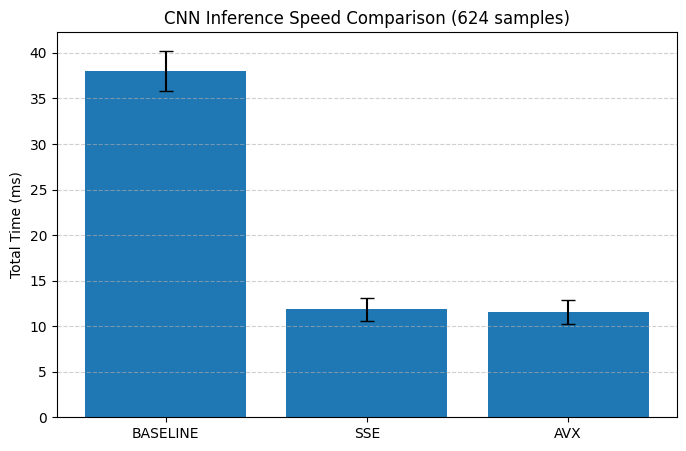

In [23]:
labels = []
means = []
stds = []

for engine in engines:
    labels.append(engine.upper())
    means.append(results[engine]["mean"])
    stds.append(results[engine]["std"])

plt.figure(figsize=(8,5))
plt.bar(labels, means, yerr=stds, capsize=5)
plt.ylabel("Total Time (ms)")
plt.title("CNN Inference Speed Comparison (624 samples)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### SIMD Speedup Analysis: 

speedup is computed as:

$$
Speedup = \frac{T_{baseline}}{T_{engine}}
$$

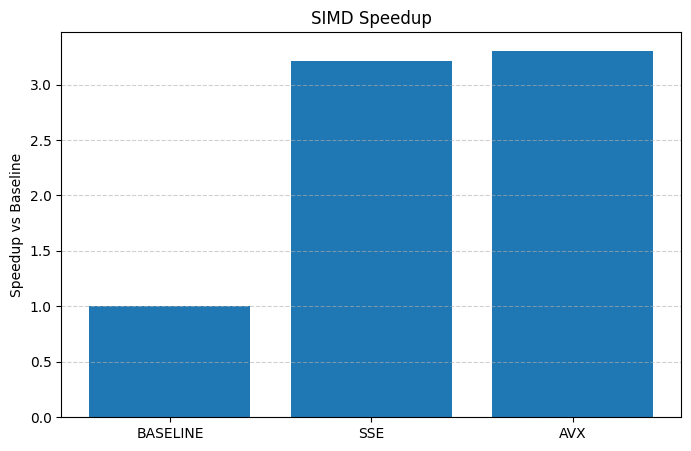

In [24]:
baseline_mean = results["baseline"]["mean"]

speedups = [
    baseline_mean / results["baseline"]["mean"],
    baseline_mean / results["sse"]["mean"],
    baseline_mean / results["avx"]["mean"]
]

plt.figure(figsize=(8,5))
plt.bar(labels, speedups)
plt.ylabel("Speedup vs Baseline")
plt.title("SIMD Speedup")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()